#### -

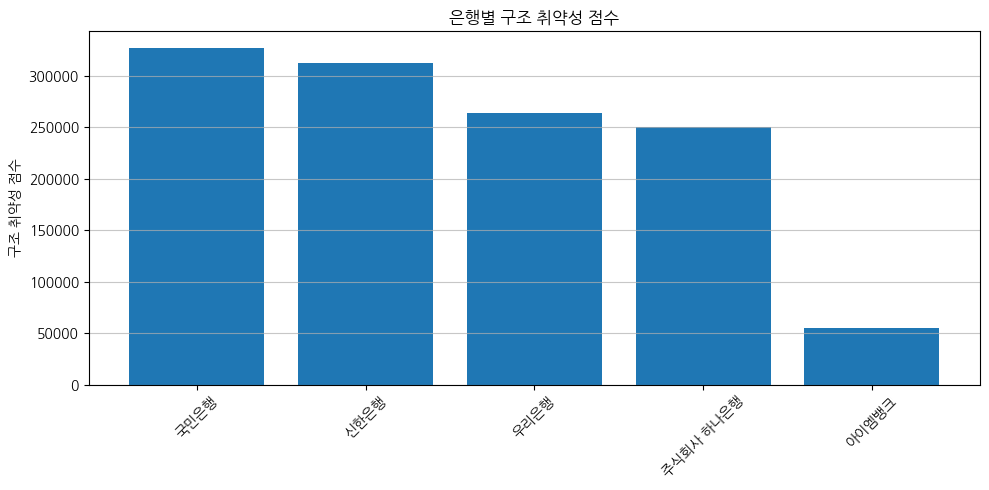

,금융회사,ΔNIM/Δ금리 β,NIM p-value,Δ이자수익/Δ금리 β,이자수익 p-value,비이자수익비율 평균,구조 취약성 점수
0,국민은행,0.047244,0.053455,691920.204724,0.000022,0.527791,326731.289695
1,신한은행,0.020923,0.399903,684152.430769,0.000002,0.543866,312065.133780
2,우리은행,0.069538,0.014715,657894.153846,0.000016,0.599430,263532.632123
3,주식회사 하나은행,0.072835,0.010408,719567.015748,0.000003,0.651686,250635.099817
4,아이엠뱅크,0.089921,0.001058,87112.779528,0.000059,0.371934,54712.538880


In [22]:
# 런타임 초기화로 인해 파일 및 코드 재실행

import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 파일 경로
profit_path = "Data/최종 프로젝트/수익성 지표 데이터.xlsx"
external_path = "Data/최종 프로젝트/외부변수.xlsx"

# 데이터 불러오기
df_profit = pd.read_excel(profit_path)
df_external = pd.read_excel(external_path)

# 열 이름 정리
def convert_quarter(col):
    if '년' in col and '월말' in col:
        year = col[:4]
        month = int(col[5:7])
        quarter = (int(month)-1)//3 + 1
        return f"{year}{quarter}/4"
    return col

df_profit.columns = [convert_quarter(c) for c in df_profit.columns]
valid_periods = [c for c in df_profit.columns if '/4' in c and c >= "20201/4"]

# 외부 변수 정리
df_ext = df_external.set_index("외부변수").T
df_ext.index.name = "분기"
df_ext = df_ext.applymap(lambda x: str(x).replace(",", "")).astype(float)
df_ext = df_ext.loc[df_ext.index >= "20201/4"]

# 분석 대상 은행
banks = ['국민은행', '신한은행', '우리은행', '주식회사 하나은행', '아이엠뱅크']

results = []

for bank in banks:
    int_df = df_profit[(df_profit["금융회사"] == bank) & (df_profit["구분"] == "이자수익")]
    int_series = int_df[valid_periods].T.squeeze().astype(float)

    nonint_df = df_profit[(df_profit["금융회사"] == bank) & (df_profit["구분"] == "비이자수익")]
    nonint_series = nonint_df[valid_periods].T.squeeze().astype(float)

    combined = pd.DataFrame({
        '이자수익': int_series,
        '비이자수익': nonint_series
    }).dropna()
    combined['합'] = combined['이자수익'] + combined['비이자수익']
    combined = combined[combined['합'] > 0]  # 음수/0 제거
    combined['비이자수익비율'] = combined['비이자수익'] / combined['합']
    bi_mean = combined['비이자수익비율'].mean()

    rate_series = df_ext['기준금리(분기말)'].astype(float).loc[combined.index]

    int_diff = combined['이자수익'].diff().dropna()
    rate_diff = rate_series.diff().dropna()
    int_diff, rate_diff = int_diff.align(rate_diff, join='inner')
    X_int = sm.add_constant(rate_diff.values.reshape(-1, 1))
    model_int = sm.OLS(int_diff.values, X_int).fit()

    nim_df = df_profit[(df_profit["금융회사"] == bank) & (df_profit["구분"] == "명목순이자마진(NIM)")]
    nim_series = nim_df[valid_periods].T.squeeze().astype(float)
    nim_diff = nim_series.diff().dropna()
    nim_diff, rate_diff2 = nim_diff.align(rate_diff, join='inner')
    X_nim = sm.add_constant(rate_diff2.values.reshape(-1, 1))
    model_nim = sm.OLS(nim_diff.values, X_nim).fit()

    구조_취약성 = model_int.params[1] * (1 - bi_mean)

    results.append({
        '금융회사': bank,
        'ΔNIM/Δ금리 β': model_nim.params[1],
        'NIM p-value': model_nim.pvalues[1],
        'Δ이자수익/Δ금리 β': model_int.params[1],
        '이자수익 p-value': model_int.pvalues[1],
        '비이자수익비율 평균': bi_mean,
        '구조 취약성 점수': 구조_취약성
    })

final_df = pd.DataFrame(results)

# 시각화
plt.figure(figsize=(10, 5))
plt.bar(final_df['금융회사'], final_df['구조 취약성 점수'])
plt.title("은행별 구조 취약성 점수")
plt.ylabel("구조 취약성 점수")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

final_df

# 진

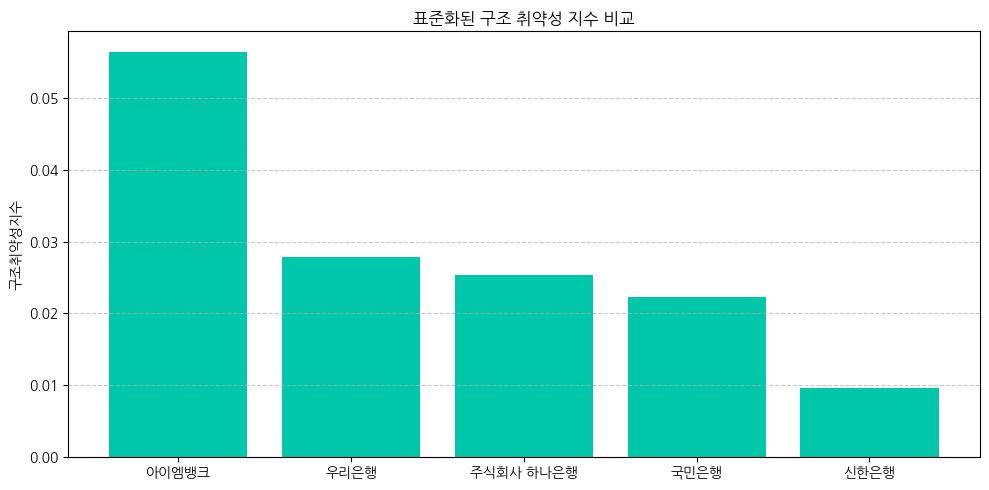

,금융회사,ΔNIM/Δ금리 β,NIM p-value,Δ이자수익/Δ금리 β,이자수익 p-value,비이자수익비율 평균,구조 취약성 점수,구조취약성_절대금액,구조취약성_구조지수
4,아이엠뱅크,0.089921,0.001058,87112.779528,0.000059,0.371934,54712.538880,54712.538880,0.056476
2,우리은행,0.069538,0.014715,657894.153846,0.000016,0.599430,263532.632123,263532.632123,0.027855
3,주식회사 하나은행,0.072835,0.010408,719567.015748,0.000003,0.651686,250635.099817,250635.099817,0.025369
0,국민은행,0.047244,0.053455,691920.204724,0.000022,0.527791,326731.289695,326731.289695,0.022309
1,신한은행,0.020923,0.399903,684152.430769,0.000002,0.543866,312065.133780,312065.133780,0.009544


In [1]:
# 런타임 초기화로 인해 파일 및 코드 재실행

import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib


# 파일 경로
profit_path = "Data/최종 프로젝트/수익성 지표 데이터.xlsx"
external_path = "Data/최종 프로젝트/외부변수.xlsx"

# 데이터 불러오기
df_profit = pd.read_excel(profit_path)
df_external = pd.read_excel(external_path)

# 열 이름 정리
def convert_quarter(col):
    if '년' in col and '월말' in col:
        year = col[:4]
        month = int(col[5:7])
        quarter = (int(month)-1)//3 + 1
        return f"{year}{quarter}/4"
    return col

df_profit.columns = [convert_quarter(c) for c in df_profit.columns]
valid_periods = [c for c in df_profit.columns if '/4' in c and c >= "20201/4"]

# 외부 변수 정리
df_ext = df_external.set_index("외부변수").T
df_ext.index.name = "분기"
df_ext = df_ext.applymap(lambda x: str(x).replace(",", "")).astype(float)
df_ext = df_ext.loc[df_ext.index >= "20201/4"]

# 분석 대상 은행
banks = ['국민은행', '신한은행', '우리은행', '주식회사 하나은행', '아이엠뱅크']

results = []

for bank in banks:
    int_df = df_profit[(df_profit["금융회사"] == bank) & (df_profit["구분"] == "이자수익")]
    int_series = int_df[valid_periods].T.squeeze().astype(float)

    nonint_df = df_profit[(df_profit["금융회사"] == bank) & (df_profit["구분"] == "비이자수익")]
    nonint_series = nonint_df[valid_periods].T.squeeze().astype(float)

    combined = pd.DataFrame({
        '이자수익': int_series,
        '비이자수익': nonint_series
    }).dropna()
    combined['합'] = combined['이자수익'] + combined['비이자수익']
    combined = combined[combined['합'] > 0]  # 음수/0 제거
    combined['비이자수익비율'] = combined['비이자수익'] / combined['합']
    bi_mean = combined['비이자수익비율'].mean()

    rate_series = df_ext['기준금리(분기말)'].astype(float).loc[combined.index]

    int_diff = combined['이자수익'].diff().dropna()
    rate_diff = rate_series.diff().dropna()
    int_diff, rate_diff = int_diff.align(rate_diff, join='inner')
    X_int = sm.add_constant(rate_diff.values.reshape(-1, 1))
    model_int = sm.OLS(int_diff.values, X_int).fit()

    nim_df = df_profit[(df_profit["금융회사"] == bank) & (df_profit["구분"] == "명목순이자마진(NIM)")]
    nim_series = nim_df[valid_periods].T.squeeze().astype(float)
    nim_diff = nim_series.diff().dropna()
    nim_diff, rate_diff2 = nim_diff.align(rate_diff, join='inner')
    X_nim = sm.add_constant(rate_diff2.values.reshape(-1, 1))
    model_nim = sm.OLS(nim_diff.values, X_nim).fit()

    구조_취약성 = model_int.params[1] * (1 - bi_mean)

    results.append({
        '금융회사': bank,
        'ΔNIM/Δ금리 β': model_nim.params[1],
        'NIM p-value': model_nim.pvalues[1],
        'Δ이자수익/Δ금리 β': model_int.params[1],
        '이자수익 p-value': model_int.pvalues[1],
        '비이자수익비율 평균': bi_mean,
        '구조 취약성 점수': 구조_취약성
    })

final_df = pd.DataFrame(results)

final_df["구조취약성_절대금액"] = final_df["Δ이자수익/Δ금리 β"] * (1 - final_df["비이자수익비율 평균"])
final_df["구조취약성_구조지수"] = final_df["ΔNIM/Δ금리 β"] * (1 - final_df["비이자수익비율 평균"])

final_df.sort_values("구조취약성_구조지수", ascending=False, inplace=True)

plt.figure(figsize=(10,5))
plt.bar(final_df["금융회사"], final_df["구조취약성_구조지수"], color='#00c7a9')
plt.title("표준화된 구조 취약성 지수 비교")
plt.ylabel("구조취약성지수")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

final_df

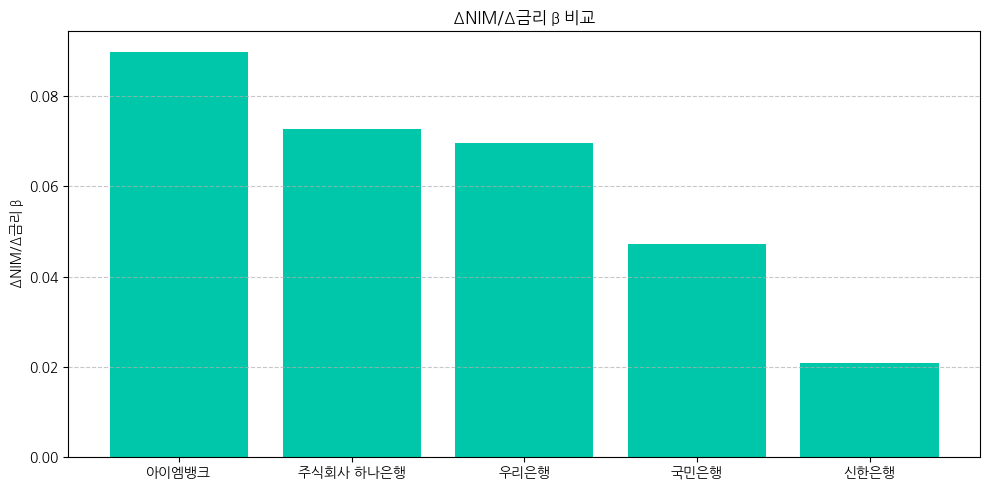

,금융회사,ΔNIM/Δ금리 β,NIM p-value,Δ이자수익/Δ금리 β,이자수익 p-value,비이자수익비율 평균,구조 취약성 점수,구조취약성_절대금액,구조취약성_구조지수
4,아이엠뱅크,0.089921,0.001058,87112.779528,0.000059,0.371934,54712.538880,54712.538880,0.056476
3,주식회사 하나은행,0.072835,0.010408,719567.015748,0.000003,0.651686,250635.099817,250635.099817,0.025369
2,우리은행,0.069538,0.014715,657894.153846,0.000016,0.599430,263532.632123,263532.632123,0.027855
0,국민은행,0.047244,0.053455,691920.204724,0.000022,0.527791,326731.289695,326731.289695,0.022309
1,신한은행,0.020923,0.399903,684152.430769,0.000002,0.543866,312065.133780,312065.133780,0.009544


In [2]:
final_df.sort_values("ΔNIM/Δ금리 β", ascending=False, inplace=True)

plt.figure(figsize=(10,5))
plt.bar(final_df["금융회사"], final_df["ΔNIM/Δ금리 β"], color='#00c7a9')
plt.title("ΔNIM/Δ금리 β 비교")
plt.ylabel("ΔNIM/Δ금리 β")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

final_df

### iM뱅크 vs 4대은행 평균

In [3]:
import pandas as pd

# ① iM뱅크 행 추출
im_df = final_df[final_df["금융회사"] == "아이엠뱅크"].copy()

# ② 시중은행 (4대 은행) 데이터 추출
market_df = final_df[final_df["금융회사"] != "아이엠뱅크"].copy()

# ③ 유의한 p-value (p < 0.05)만 필터링하여 평균 계산
nim_p_mean_sig = market_df.loc[market_df["NIM p-value"] < 0.05, "NIM p-value"].mean()
int_p_mean_sig = market_df.loc[market_df["이자수익 p-value"] < 0.05, "이자수익 p-value"].mean()

# ④ 그 외의 수치는 단순 평균 계산
market_avg = market_df.mean(numeric_only=True).to_frame().T
market_avg["금융회사"] = "4대 시중은행 평균"

# ⑤ 유의한 p-value 평균값으로 덮어쓰기
market_avg["NIM p-value"] = nim_p_mean_sig
market_avg["이자수익 p-value"] = int_p_mean_sig

# ⑥ iM뱅크와 결합
comparison_df = pd.concat([im_df, market_avg], ignore_index=True)

# ⑦ 열 순서 정렬 (선택)
cols_order = [
    "금융회사", "ΔNIM/Δ금리 β", "NIM p-value",
    "Δ이자수익/Δ금리 β", "이자수익 p-value",
    "비이자수익비율 평균", "구조 취약성 점수",
    "구조취약성_절대금액", "구조취약성_구조지수"
]
comparison_df = comparison_df[cols_order]

# ⑧ 결과 출력
comparison_df = comparison_df.drop(["NIM p-value", "이자수익 p-value"], axis=1)
comparison_df

,금융회사,ΔNIM/Δ금리 β,Δ이자수익/Δ금리 β,비이자수익비율 평균,구조 취약성 점수,구조취약성_절대금액,구조취약성_구조지수
0,아이엠뱅크,0.089921,87112.779528,0.371934,54712.538880,54712.538880,0.056476
1,4대 시중은행 평균,0.052635,688383.451272,0.580693,288241.038853,288241.038853,0.021269


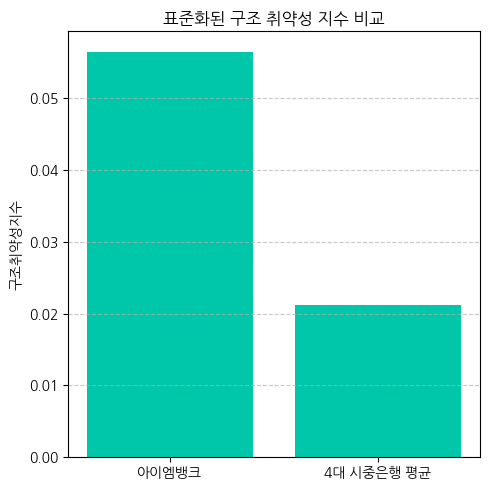

In [4]:
plt.figure(figsize=(5,5))
plt.bar(comparison_df["금융회사"], comparison_df["구조취약성_구조지수"], color='#00c7a9')
plt.title("표준화된 구조 취약성 지수 비교")
plt.ylabel("구조취약성지수")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib


# 파일 경로
profit_path = "Data/최종 프로젝트/수익성 지표 데이터.xlsx"
external_path = "Data/최종 프로젝트/외부변수.xlsx"

# 데이터 불러오기
df_profit = pd.read_excel(profit_path)
df_external = pd.read_excel(external_path)

In [6]:
df_profit

,금융회사,금융회사코드,권역금융회사코드,구분,코드,2014년03월말,2014년06월말,2014년09월말,2014년12월말,2015년03월말,...,2022년09월말,2022년12월말,2023년03월말,2023년06월말,2023년09월말,2023년12월말,2024년03월말,2024년06월말,2024년09월말,2024년12월말
0,국민은행,10927,10927,자산총계,A,2.638028e+08,2.636879e+08,2.652086e+08,2.712526e+08,2.778211e+08,...,5.175632e+08,5.003435e+08,4.937454e+08,5.063948e+08,5.190497e+08,5.123728e+08,5.259998e+08,5.333354e+08,5.340966e+08,5.435964e+08
1,국민은행,10927,10927,영업수익,B,3.718896e+06,4.362944e+06,3.776380e+06,4.214011e+06,3.758809e+06,...,2.029524e+07,3.219445e+06,1.400498e+07,8.229987e+06,1.063737e+07,9.840400e+06,1.395939e+07,1.133553e+07,7.329498e+06,1.717059e+07
2,국민은행,10927,10927,이자수익,C,2.448245e+06,2.452545e+06,2.408592e+06,2.354340e+06,2.216547e+06,...,3.659136e+06,4.571530e+06,4.928166e+06,5.137662e+06,5.359121e+06,5.604474e+06,5.499491e+06,5.471744e+06,5.468664e+06,5.439757e+06
3,국민은행,10927,10927,비이자수익,D,1.254178e+06,1.897395e+06,1.373603e+06,1.842587e+06,1.561338e+06,...,1.679461e+07,-1.154959e+06,9.630259e+06,3.311698e+06,5.165332e+06,4.447237e+06,8.542740e+06,5.968568e+06,1.993531e+06,1.156923e+07
4,국민은행,10927,10927,총자산순이익률(ROA),E,NaN,NaN,NaN,3.300000e-01,NaN,...,5.900000e-01,6.000000e-01,5.700000e-01,6.200000e-01,6.700000e-01,6.000000e-01,3.000000e-01,4.600000e-01,6.500000e-01,5.800000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,한국씨티은행,10006,10006,자기자본순이익률(ROE),F,NaN,NaN,NaN,2.160000e+00,NaN,...,-1.364000e+01,2.610000e+00,3.390000e+00,4.310000e+00,4.490000e+00,4.780000e+00,5.020000e+00,5.980000e+00,6.030000e+00,5.310000e+00
66,한국씨티은행,10006,10006,명목순이자마진(NIM),G,2.770000e+00,2.740000e+00,2.740000e+00,2.730000e+00,2.500000e+00,...,2.160000e+00,2.290000e+00,2.600000e+00,2.580000e+00,2.570000e+00,2.640000e+00,2.920000e+00,2.940000e+00,2.850000e+00,2.770000e+00
67,한국씨티은행,10006,10006,원화예대금리차,H,3.860000e+00,3.730000e+00,3.690000e+00,3.660000e+00,3.270000e+00,...,3.080000e+00,3.170000e+00,3.440000e+00,3.380000e+00,3.370000e+00,3.440000e+00,3.860000e+00,3.960000e+00,3.680000e+00,3.570000e+00
68,한국씨티은행,10006,10006,BIS비율,I,1.815000e+01,1.688000e+01,1.667000e+01,1.690000e+01,1.661000e+01,...,1.742000e+01,2.072000e+01,2.754000e+01,2.806000e+01,2.787000e+01,3.259000e+01,3.274000e+01,3.271000e+01,3.422000e+01,3.428000e+01
